# This momentum strategy is a replicate of https://teddykoker.com/2019/05/momentum-strategy-from-stocks-on-the-move-in-python/ with help from Sal, who creates pyqstrat. I want to replicate because backtrader is slower.

In [1]:
import math
import datetime
import numpy as np
import os

import pandas as pd
import statsmodels.api as sm
from statsmodels.regression.rolling import RollingOLS
import matplotlib.pyplot as plt
import scipy.stats
import datetime
from types import SimpleNamespace
import pyqstrat as pq

pq.set_defaults() # Set some display defaults to make dataframes and plots easier to look at
import pathlib
pwd = pathlib.Path.cwd()

In [11]:
import random
stocks = (pwd. / 'China_A_Share_Stocks').glob('*.csv')
init_symbols = random.sample([stock.stem for stock in stocks], k=3000)

In [12]:
prices = []
symbols = []
for symbol in init_symbols:
    df = pd.read_csv(f'./China_A_Share_Stocks/{symbol}.csv',usecols=['trade_date', 'open', 'high', 'low', 'close']).rename(columns={'trade_date':'date'})
    if df['date'].min() > 20180101:
        continue
    else:
        df = df.sort_values(by = ['date'])
        df = df.drop_duplicates(subset=['date'])
        df.date = df.date.astype(str)
        df = df.set_index('date')
        symbol = symbol.split('.')[0]
        df.columns = [f'{symbol}_o', f'{symbol}_h', f'{symbol}_l', f'{symbol}_c']
        symbols.append(symbol)
        prices.append(df)

In [13]:
prices_df = pd.concat(prices, axis=1, sort=True)
prices_df.index.name = 'date'
prices_df['timestamp'] = pd.to_datetime(prices_df.index.values)
mask = (prices_df['timestamp'] >= '2015-1-1') & (prices_df['timestamp'] <= '2020-1-10')
prices_df = prices_df.loc[mask]
prices_df = prices_df.reset_index(drop=True)
prices_df = prices_df.set_index('timestamp')
timestamps = prices_df.index.values
del prices

In [14]:
def momentum_indicator(contract_group, timestamps, indicators, strategy_context):
    endog = np.log(indicators.c)
    exog = sm.add_constant(np.arange(len(endog)))
    rres = RollingOLS(endog, exog, window=60, min_nobs=40).fit()
    return ((1 + rres.params[:,1]) ** 252) * (rres.rsquared_adj ** 2)


def sma_indicator(contract_group, timestamps, indicators, strategy_context):
    sma = pd.Series(indicators.c).rolling(window = strategy_context.sma_period).mean()
    return sma.values

def atr(df, n=14):
    data = df.copy()
    high = data['h']
    low = data['l']
    close = data['c']
    data['tr0'] = abs(high - low)
    data['tr1'] = abs(high - close.shift())
    data['tr2'] = abs(low - close.shift())
    tr = data[['tr0', 'tr1', 'tr2']].max(axis=1)
    atr = tr.ewm(alpha=1/n, min_periods=n, adjust=False).mean()
    return atr
def atr_indicator(contract_group, timestamps, indicators, strategy_context): 
    period = strategy_context.atr_period
    df = pd.DataFrame({'h':indicators.h,'l':indicators.l,'c':indicators.c})
    return atr(df, n=strategy_context.atr_period)
def get_price(contract_group, timestamps, i, strategy_context):
    if contract_group.symbol in strategy_context.symbols:
        return strategy_context.prices_df[contract_group.symbol+'_c'][i]
    raise Exception(f'Unknown symbol: {symbol}')


In [15]:
strategy_context = SimpleNamespace(prices_df=prices_df, symbols=symbols, sma_period=100, atr_period=20)
strategy_context.weekday = np.array([datetime.datetime.utcfromtimestamp(x.astype(int)*1e-9).isoweekday() for x in timestamps])

pq.ContractGroup.clear()
pq.Contract.clear()
contract_groups = {symbol: pq.ContractGroup.create(symbol) for symbol in symbols}
strategy = pq.Strategy(timestamps=timestamps,
                    contract_groups=list(contract_groups.values()), 
                    price_function=get_price,
                       trade_lag = 1,
                    strategy_context=strategy_context)

for column in prices_df.columns:
    symbol = column.split('_')[0]
    value_name = column.split('_')[1]
    strategy.add_indicator(value_name, prices_df[column].values, [contract_groups[symbol]])

In [16]:
strategy.add_indicator('momentum_ind', momentum_indicator, depends_on = ['c'])
strategy.add_indicator('sma_ind', sma_indicator, depends_on = ['c'])
strategy.add_indicator('atr_ind', atr_indicator, depends_on = ['h', 'l', 'c'])
strategy.run_indicators()

In [17]:
df = {}
for symbol in symbols:
    df[symbol]=strategy.indicator_values[contract_groups[symbol]].momentum_ind
df = pd.DataFrame(df)
ranks = df.rank(1, ascending=True, method='first', pct=True)
strategy_context.mom_rank = ranks
def momentum_rank_indicator(contract_group, timestamps, indicators, strategy_context):
    return  strategy_context.mom_rank[contract_group.name].values

strategy.add_indicator('momentum_rank_ind', momentum_rank_indicator)
strategy.run_indicators(indicator_names = ['momentum_rank_ind'])

In [18]:
def momentum_strategy_signal(contract_group, timestamps, indicators, parent_signals, strategy_context): 
    signal = np.where(np.nan_to_num(indicators.momentum_rank_ind) <= 0.1, 1, -1)
    signal = np.where(np.nan_to_num(indicators.sma_ind) > np.nan_to_num(indicators.c), -1, signal)
    signal = np.where(strategy_context.weekday != 3, 0, signal) 
    signal[0:max(strategy_context.sma_period, strategy_context.atr_period)] = 0
    return signal
strategy.add_signal('momentum_strategy_signal', momentum_strategy_signal, depends_on_indicators = ['momentum_rank_ind','c','sma_ind'])

def momentum_trading_rule(contract_group, i, timestamps, indicators, signal, account, strategy_context):

    orders = []
    timestamp = timestamps[i]
    curr_equity = account.equity(timestamp)
    curr_pos = account.position(contract_group, timestamp)
    signal_value = signal[i]
    risk_percent = 0.001
    close_price = indicators.c[i]
    symbol = contract_group.name
    atr = indicators.atr_ind[i]

    contract = contract_group.get_contract(symbol)
    if contract is None:
        contract = pq.Contract.create(symbol, contract_group = contract_group)
    
    
    # if we don't already have a position, check if we should enter a trade
    if math.isclose(curr_pos, 0):
        if signal_value == 1 and np.isfinite(atr) and atr > 0.01 and np.isfinite(close_price):
            order_qty = np.round(curr_equity * risk_percent / (atr*close_price) * np.sign(signal_value))
            if not math.isclose(order_qty, 0):
                trigger_price = close_price
                reason_code = pq.ReasonCode.ENTER_LONG if order_qty > 0 else pq.ReasonCode.ENTER_SHORT
                order = pq.StopLimitOrder(contract, timestamp, order_qty, trigger_price, reason_code = reason_code)
                orders.append(order)
                #print(f'Enter:{order}')
    else: # We have a current position, so check if we should exit
        if curr_pos > 0 and signal_value == -1:
            order_qty = -curr_pos
            reason_code = pq.ReasonCode.EXIT_LONG if order_qty < 0 else pq.ReasonCode.EXIT_SHORT
            order = pq.MarketOrder(contract, timestamp, order_qty, reason_code = reason_code)
            orders.append(order)
            #print(f'Exit:{order}')
   
    return orders
strategy.add_rule('momentum_trading_rule', momentum_trading_rule, 
                  signal_name = 'momentum_strategy_signal', sig_true_values = [-1, 1])

def market_simulator(orders, i, timestamps, indicators, signals, strategy_context):
    trades = []
    
    timestamp = timestamps[i]
    
    for order in orders:
        cgroup = order.contract.contract_group
        ind = indicators[cgroup]
        o, h, l, c = ind.o[i], ind.h[i], ind.l[i], ind.c[i]
        
        trade_price = np.nan
        
        if isinstance(order, pq.MarketOrder):
            trade_price = 0.5 * (o + h) if order.qty > 0 else 0.5 * (o + l)
        elif isinstance(order, pq.StopLimitOrder):
            if (order.qty > 0 and h > order.trigger_price) or (order.qty < 0 and l < order.trigger_price): # A stop order
                trade_price = 0.5 * (order.trigger_price + h) if order.qty > 0 else 0.5 * (order.trigger_price + l)
        else:
            raise Exception(f'unexpected order type: {order}')
            
        if np.isnan(trade_price): continue
            
        trade = pq.Trade(order.contract, order, timestamp, order.qty, trade_price, commission = 0, fee = 0)
        #print(f'Trade:{trade}')
        order.status = 'filled'
                           
        trades.append(trade)
                           
    return trades
strategy.add_market_sim(market_simulator)

,gmean,amean,std,shrp,srt,k,calmar,mar,mdd_pct,mdd_dates,dd_3y_pct,dd_3y_timestamps,up_dwn,2015,2016,2017,2018,2019,2020
,-0.07728,-0.0663,0.01145,-0.3648,-0.5282,0.7626,-0.3386,-0.1292,0.5133,2016-11-14/2019-01-31,0.4794,2017-01-10/2019-01-31,583/542/0.518,0.123,-0.0239,-0.2059,-0.292,0.0232,8.163


<Figure size 576x432 with 0 Axes>

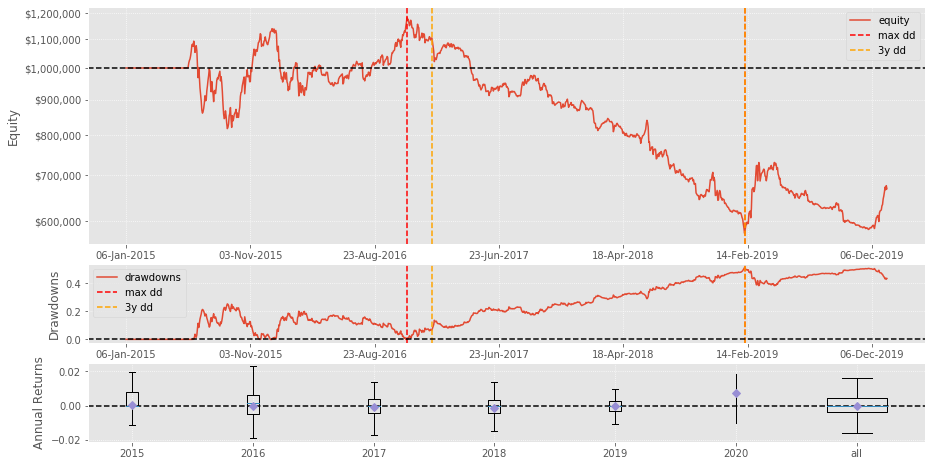

In [19]:
strategy.run()
strategy.evaluate_returns()

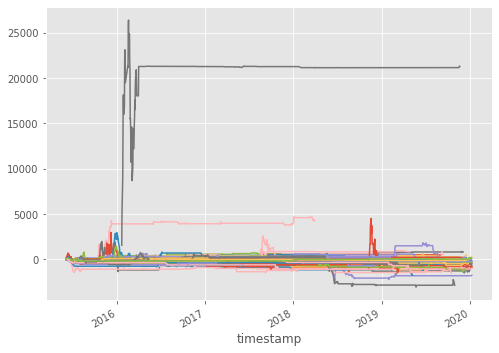

In [84]:
pnl = strategy.account.df_pnl()[['timestamp','symbol','net_pnl']].pivot(index='timestamp',columns='symbol',values='net_pnl')
pnl.plot(legend=False)

In [85]:
pnl.loc[:, pnl.max() > 20000].loc['20160101':'20160131']

symbol,002624
timestamp,
2016-01-04,nan
2016-01-05,nan
2016-01-06,nan
2016-01-07,nan
2016-01-08,nan
2016-01-11,nan
2016-01-12,nan
2016-01-13,nan
2016-01-14,nan


In [70]:
strategy.df_trades().query("symbol == '002624'")

,symbol,timestamp,qty,price,fee,commission,order_date,order_qty,reason_code,order_props,contract_props
157,002624,2016-01-21,29077,23.8982,0,0,2016-01-20,29077,enter long,"{'trigger_price': 22.7616, 'limit_price': nan}",
192,002624,2016-03-31,-29077,39.235,0,0,2016-03-30,-29077,exit long,,
206,002624,2016-04-28,626,39.7664,0,0,2016-04-27,626,enter long,"{'trigger_price': 38.6741, 'limit_price': nan}",
209,002624,2016-05-05,-626,41.1982,0,0,2016-05-04,-626,exit long,,
215,002624,2016-05-12,573,33.6799,0,0,2016-05-11,573,enter long,"{'trigger_price': 32.5728, 'limit_price': nan}",
219,002624,2016-05-19,-573,33.68975,0,0,2016-05-18,-573,exit long,,
364,002624,2016-10-13,421,34.8359,0,0,2016-10-12,421,enter long,"{'trigger_price': 34.6635, 'limit_price': nan}",
425,002624,2016-12-08,-421,32.56535,0,0,2016-12-07,-421,exit long,,
500,002624,2017-03-16,1236,31.2947,0,0,2017-03-15,1236,enter long,"{'trigger_price': 30.881, 'limit_price': nan}",
508,002624,2017-03-23,-1236,30.2308,0,0,2017-03-22,-1236,exit long,,
